<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/AutoMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Back of the Napkin Implementation of Something Similar to AutoMix
AutoMix uses some fairly complex POMDP. I think this covers the essence of the approach without those complexities.

# LLM Self Evaluation to probability
One of the key ideas of AutoMix is to turn self-evaluation into a probability distribution by asking the model to self evaluate a few times with a high temperature, thus turning self evaluation into a probability distribution.

In [49]:
!pip install OpenAI
!pip install langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13


In [50]:
from google.colab import userdata
import openai
import os

api_key = userdata.get('OpenAIAPIKey')
os.environ['OPENAI_API_KEY'] = api_key

In [51]:
"""Creating an "evaluator" using langchain's "with_structured_output".
Basically, this function defines a class which has the data we want from the
LLM, then langchain uses that class to format the LLMs response into a true
or false judgement of if the model was accurate or not.

This has a high temperature, meaning using an evaluator multiple times
can result in a distribution of evaluations
"""

from typing import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def create_evaluator(model):

    #Defines the structure of the output
    class SelfEval(TypedDict):
        rationale: str
        judgement: bool

    #The system prompt provided to the model
    #prompt lightly modified from AutoMix paper
    self_eval_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """Instruction: Your task is to evaluate if the AI Generated Answer is correct or incorrect based on the
provided context and question. Provide ultimate reasoning that a human would be satisfied with, then choose between
Correct (True) or Incorrect (False).
                """,
            ),
            ("placeholder", "{messages}"),
        ]
    )

    #creating a lang chang that outputs structured output
    evaluator = self_eval_prompt | ChatOpenAI(
        model=model, temperature=1 #setting a high temperature
    ).with_structured_output(SelfEval)

    return evaluator

In [52]:
from openai import OpenAI

model = 'gpt-3.5-turbo'
# model = 'gpt-4o'

evaluator = create_evaluator(model)

# Example 1
context = """There was a plane crash in which every single person was killed. Yet there were 12 survivors. How?"""
question = "Solve the riddle"

client = OpenAI(api_key=api_key)
response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": f"context:\n{context}\n\nquestion:\n{question}"}
            ],
    )

answer = response.choices[0].message.content.strip()
# answer = "The riddle is referring to the survivors being the 12 months of the year."

evaluation = evaluator.invoke({"messages": [("user", f"""Context: {context}
Question: {question}
AI Generated Answer: {answer}""")]})

print('==== Context ====')
print(context)
print('==== Question =====')
print(question)
print('===== LLM Answer =====')
print(answer)
print('===== Evaluation Details =====')
print(evaluation)
print('===== Final evaluation =====')
print(evaluation['judgement'])

==== Context ====
There was a plane crash in which every single person was killed. Yet there were 12 survivors. How?
==== Question =====
Solve the riddle
===== LLM Answer =====
The answer to this riddle is that the 12 survivors were married couples.
===== Evaluation Details =====
{'rationale': 'The riddle states that every single person was killed in the plane crash, indicating individual passengers. Therefore, the answer that the 12 survivors were married couples is incorrect as it does not align with the context provided.', 'judgement': False}
===== Final evaluation =====
False


evaluator error


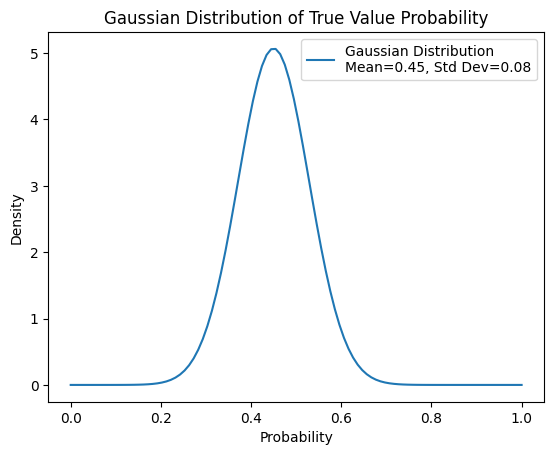

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def gaussianize_answer(context, question, answer):
    num_evaluations = 40
    evaluations = []
    evaluator = create_evaluator(model)

    for _ in range(num_evaluations):

        for i in range(2):
            #allowing the evaluator to make several judgements
            #also wrapping it in a try/catch to deal with the odd parsing error.

            #printouts are a good way to see if there's an actually problem or if the one offs
            #are inconsequential
            try:
                evaluation = evaluator.invoke({"messages": [("user", f"""Context: {context}
            Question: {question}
            AI Generated Answer: {answer}""")]})

                evaluations.append(evaluation['judgement'])
                break
            except KeyboardInterrupt as e:
                raise e
            except:
                print('evaluator error')
        else:
            print('too many errors, skipping evaluation step')

    # Calculate probability (mean) of True values
    probability = sum(evaluations) / len(evaluations)

    # Define parameters for the Gaussian plot
    # Assuming a binomial distribution normalized for a Gaussian approximation
    mean = probability
    std_dev = np.sqrt(probability * (1 - probability) / len(evaluations))

    return mean, std_dev

mean, std_dev = gaussianize_answer(context, question, answer)

#cant draw gaussian if there's perfect consensus
if mean != 0 and mean !=1:
    # Create a range for x values
    x = np.linspace(0, 1, 100)
    y = norm.pdf(x, mean, std_dev)

    # Plot the Gaussian
    plt.plot(x, y, label=f'Gaussian Distribution\nMean={mean:.2f}, Std Dev={std_dev:.2f}')
    plt.title("Gaussian Distribution of True Value Probability")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [58]:
#A selection of a few hardcoded LLM answers
llm_answers = []
llm_answers.append("The 12 survivors were married couples.")
llm_answers.append("The people on the plane were all couples - husbands and wives.")
llm_answers.append("The answer to this riddle is that the 12 survivors were married couples.")
llm_answers.append("The riddle is referring to the survivors being the 12 months of the year.")
llm_answers.append("The riddle is referring to the survivors as the numbers on a clock (numbers 1-12). So, the answer is that the \"12 survivors\" are actually the numbers on a clock.")

#evaluating all answers
distributions = []
for llm_answer in llm_answers:
    mean, std = gaussianize_answer(context, question, llm_answer)
    distributions.append((mean, std))

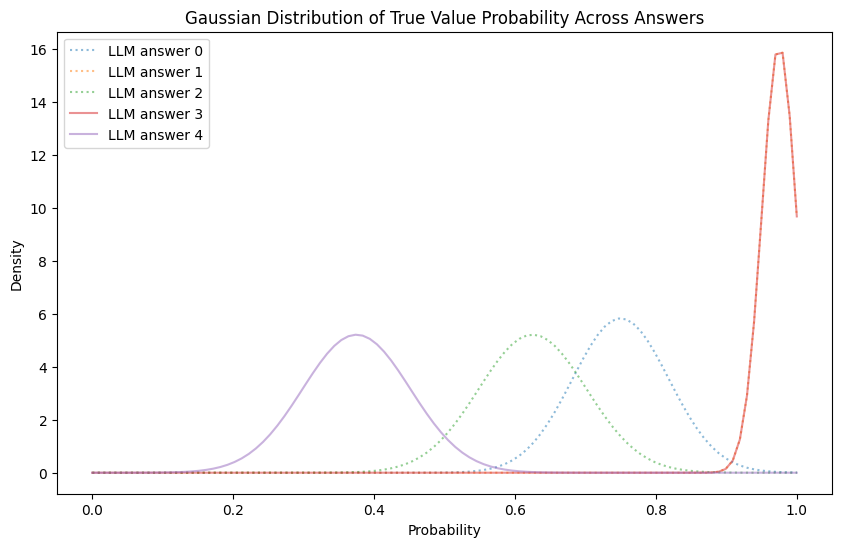

In [59]:
fig = plt.figure(figsize=(10, 6))

#plotting all gaussians
for i, dist in enumerate(distributions):
    #unpacking tuple
    mean, std = dist

    name = f'LLM answer {i}'

    #labeling the two clearly wrong answers as dotted lines (i=3 and i=4)
    if i>=3:
        stroke = '-'
    else:
        stroke=':'

    if std == 0:
        plt.plot([mean,mean],[0,1], linestyle=stroke, label=name)
    else:
        # Create a range for x values
        x = np.linspace(0, 1, 100)
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, linestyle=stroke, label=name, alpha=0.5)
plt.title("Gaussian Distribution of True Value Probability Across Answers")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

# Notes:
Self evaluation is kind of cool, but a major issue is that the same dumb model has a tendency to agree with its own wrong answers. AKA self preference. https://arxiv.org/html/2404.13076v1

Also, based on my exploration, self evaluation is very, very noisy indeed. Seems to be influenced by both the question and, I suspect, the LLM. I imagine the profile of this would change drastically.

# Kernel Density Estimation For Quality
We can use a small dataset with self evaluation results to get an idea of how a particular models self evaluation alligns with true performance.

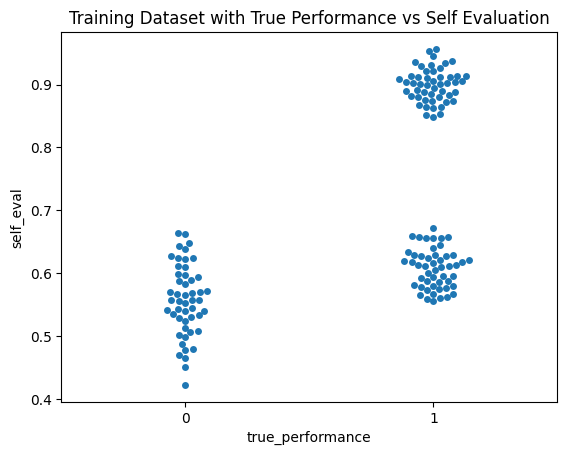

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Creating a synthetic dataset with self evaluation results
# and actual performance results.
np.random.seed(0)

n_each = 50

selfeval_bad = np.random.normal(0.55, 0.05, n_each)    # Lower confidence around 0.4
selfeval_good_1 = np.random.normal(0.9, 0.03, n_each)  # Higher confidence around 0.7
selfeval_good_2 = np.random.normal(0.6, 0.03, n_each)  # Higher confidence around 0.6
selfeval_good = np.concatenate([selfeval_good_1, selfeval_good_2]) #combining both good distributions
self_eval = np.concatenate([selfeval_good_1, selfeval_good_2, selfeval_bad])
true_performance = [1] * (n_each*2) + [0] * n_each

#plotting a swarm plot
df = pd.DataFrame()
df['true_performance'] = true_performance
df['self_eval'] = self_eval

ax = sns.swarmplot(x="true_performance", y="self_eval", data=df)
plt.title("Training Dataset with True Performance vs Self Evaluation")

plt.show()

<Axes: xlabel='self_eval'>

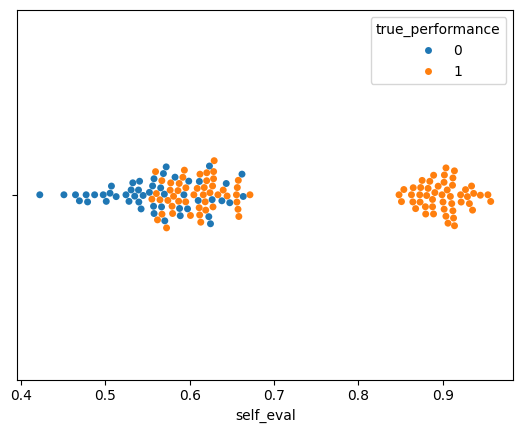

In [61]:
sns.swarmplot(x = 'self_eval', data = df, hue='true_performance')

Text(0.5, 36.72222222222228, 'Individual good self evaluations')

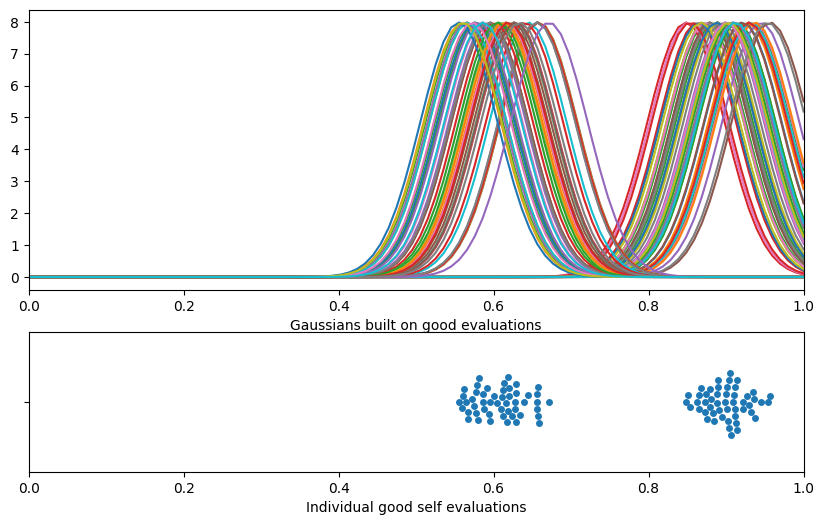

In [62]:
import matplotlib.gridspec as gridspec
from scipy.stats import norm

fig = plt.figure(figsize=(10, 6))

# Creating a gaussian distribution with a small deviation on every point in a set of data
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
std = 0.05
for mean in selfeval_good:
    x = np.linspace(0, 1, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x,y)
plt.xlim([0, 1])
plt.xlabel("Gaussians built on good evaluations")

ax2 = fig.add_subplot(gs[1])
sns.swarmplot(x = 'self_eval', data = df[df['true_performance']==1])
plt.xlim([0, 1])
plt.xlabel("Individual good self evaluations")

Text(0.5, 36.72222222222228, 'Individual good self evaluations')

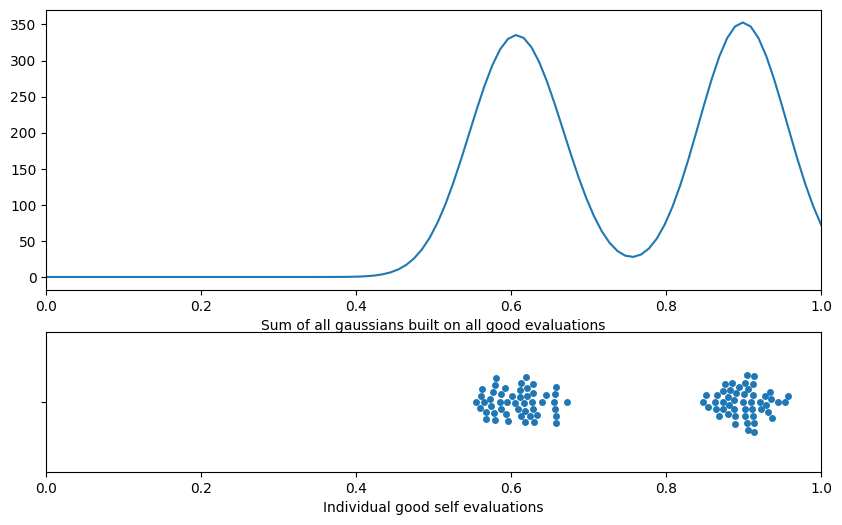

In [63]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6))

# Creating a gaussian distribution with a small deviation on every point in a set of data
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
std = 0.05
y = np.zeros(100)
for mean in selfeval_good:
    x = np.linspace(0, 1, 100)
    y += norm.pdf(x, mean, std)
plt.plot(x,y)
plt.xlim([0, 1])
plt.xlabel("Sum of all gaussians built on all good evaluations")

ax2 = fig.add_subplot(gs[1])
sns.swarmplot(x = 'self_eval', data = df[df['true_performance']==1])
plt.xlim([0, 1])
plt.xlabel("Individual good self evaluations")

Text(0.5, 36.72222222222228, 'Individual good self evaluations')

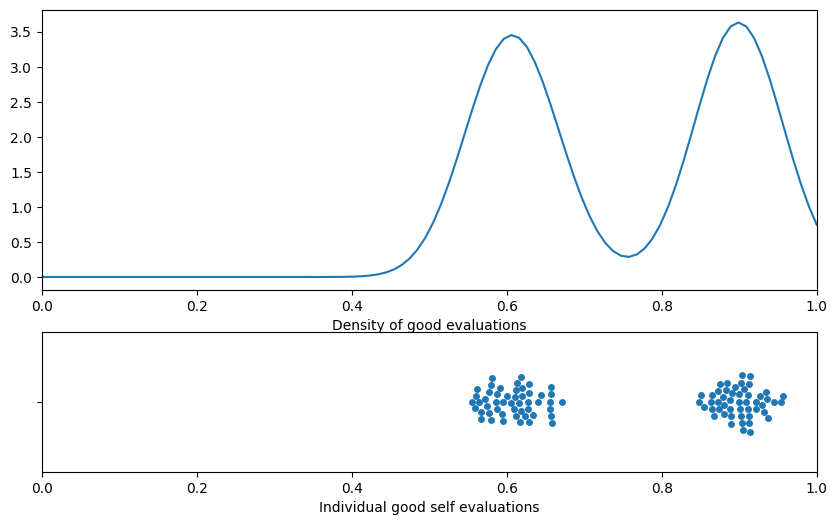

In [64]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6))

# Creating a gaussian distribution with a small deviation on every point in a set of data
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
std = 0.05
y = np.zeros(100)
for mean in selfeval_good:
    x = np.linspace(0, 1, 100)
    y += norm.pdf(x, mean, std)

#converting to density (total area under the curve, regardless of the number
#of samples, will be equal to 1. Densities beteen distributions are comperable even
#if the number of samples are different)
area_under_curve = np.trapz(y, dx=1/100)
y = y/area_under_curve

plt.plot(x,y)
plt.xlim([0, 1])
plt.xlabel("Density of good evaluations")

ax2 = fig.add_subplot(gs[1])
sns.swarmplot(x = 'self_eval', data = df[df['true_performance']==1])
plt.xlim([0, 1])
plt.xlabel("Individual good self evaluations")

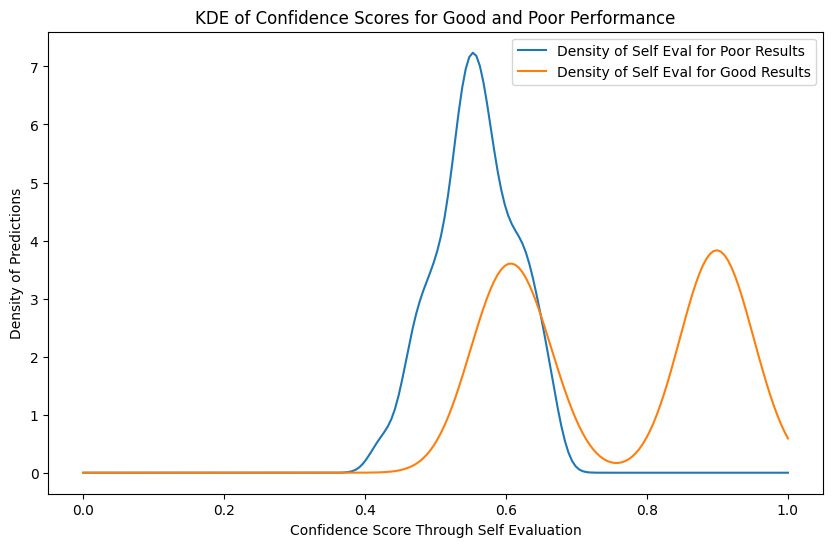

In [65]:
from scipy.stats import gaussian_kde

# Perform KDE for each performance state
good_kde = gaussian_kde(selfeval_good, bw_method=0.3)
poor_kde = gaussian_kde(selfeval_bad, bw_method=0.3)

# Define a range of confidence scores for visualization
confidence_range = np.linspace(0, 1.0, 200)

# Evaluate KDEs over the range of confidence scores
good_density = good_kde(confidence_range)
poor_density = poor_kde(confidence_range)

# Plot the KDE for each performance state
plt.figure(figsize=(10, 6))
plt.plot(confidence_range, poor_density, label="Density of Self Eval for Poor Results")
plt.plot(confidence_range, good_density, label="Density of Self Eval for Good Results")
plt.title("KDE of Confidence Scores for Good and Poor Performance")
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Density of Predictions")
plt.legend()
plt.show()

---
# note on scale
KDE is indeed a *density* estimation, not a volume estimation. AUC is 1.

Text(0, 0.5, 'Density of Predictions')

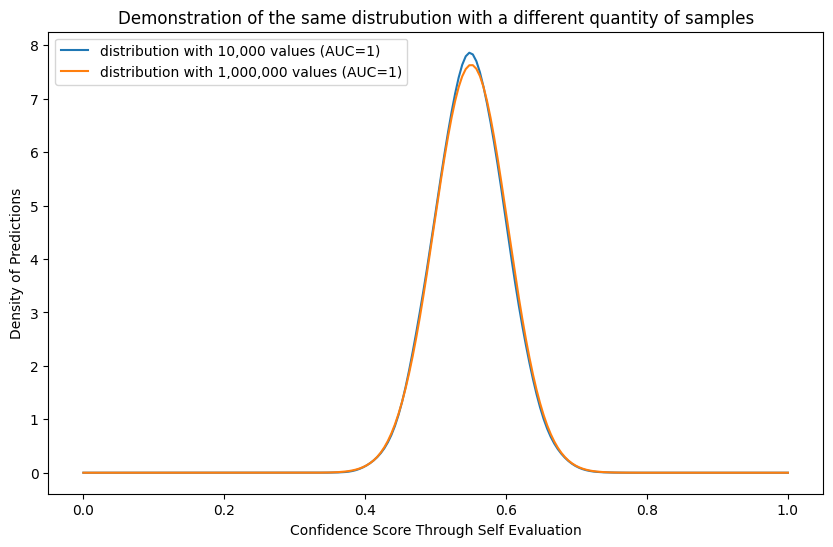

In [66]:

small_number_samples = np.random.normal(0.55, 0.05, 10_000)
large_number_samples = np.random.normal(0.55, 0.05, 1_000_000)

small_kde = gaussian_kde(small_number_samples, bw_method=0.3)
large_kde = gaussian_kde(large_number_samples, bw_method=0.3)

small_number_density = small_kde(confidence_range)
large_dumber_density = large_kde(confidence_range)

plt.figure(figsize=(10, 6))
plt.title("Demonstration of the same distrubution with a different quantity of samples")
plt.plot(confidence_range, small_number_density, label="distribution with 10,000 values (AUC=1)")
plt.plot(confidence_range, large_dumber_density, label="distribution with 1,000,000 values (AUC=1)")
plt.legend()
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Density of Predictions")

---

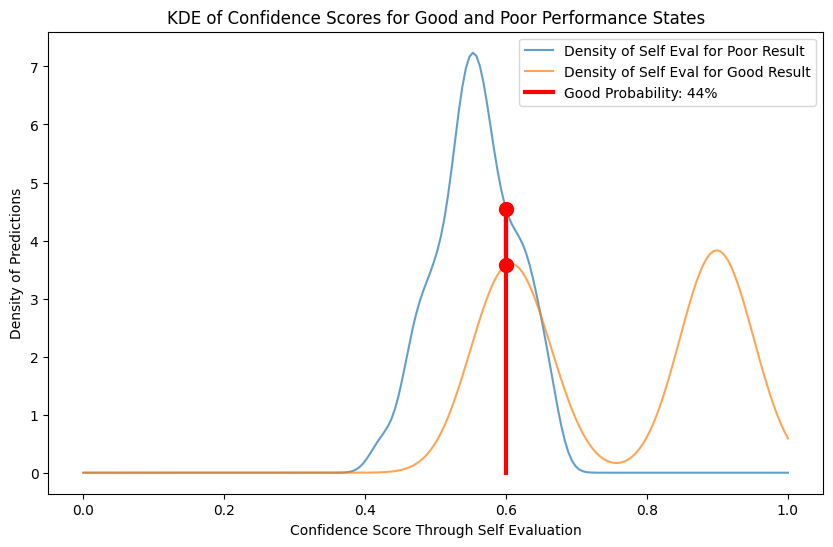

In [67]:
# Plot the KDE for each performance state
plt.figure(figsize=(10, 6))
plt.plot(confidence_range, poor_density, label="Density of Self Eval for Poor Result", alpha=0.7)
plt.plot(confidence_range, good_density, label="Density of Self Eval for Good Result", alpha=0.7)

#plotting the probabilities of good or bad at a given location
sample_confidence = 0.6
conf_poor = poor_kde(sample_confidence)[0]
conf_good =  good_kde(sample_confidence)[0]
label = f'Good Probability: {int(conf_good/(conf_poor+conf_good)*100)}%'
plt.plot([sample_confidence]*3,[0,conf_poor, conf_good], 'r', linewidth=3, label=label)
plt.plot([sample_confidence]*2,[conf_poor, conf_good], 'r', marker='o', markersize=10)

plt.title("KDE of Confidence Scores for Good and Poor Performance States")
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Density of Predictions")
plt.legend()
plt.show()

Text(0, 0.5, 'Probability Correct')

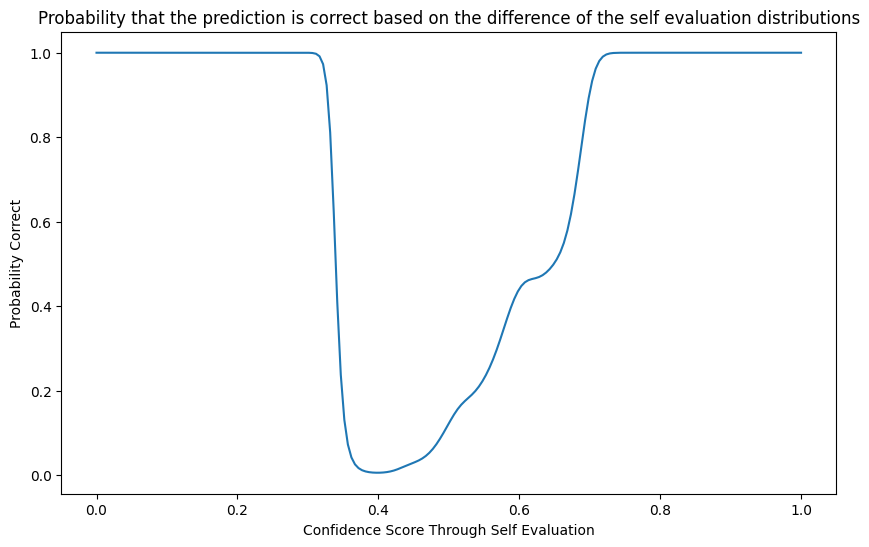

In [68]:
plt.figure(figsize=(10, 6))
plt.title("Probability that the prediction is correct based on the difference of the self evaluation distributions")
good_probability = np.array([good/(good+poor) for (good, poor) in zip(good_density, poor_density)])
plt.plot(confidence_range, good_probability)
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Probability Correct")

# Kernel Density Estimation for General Likelihood
One might get an odd prediction which is very atypical. This can be used to bolster the robustness of autoeval by, say, being highly skeptical of atypically confident answers.

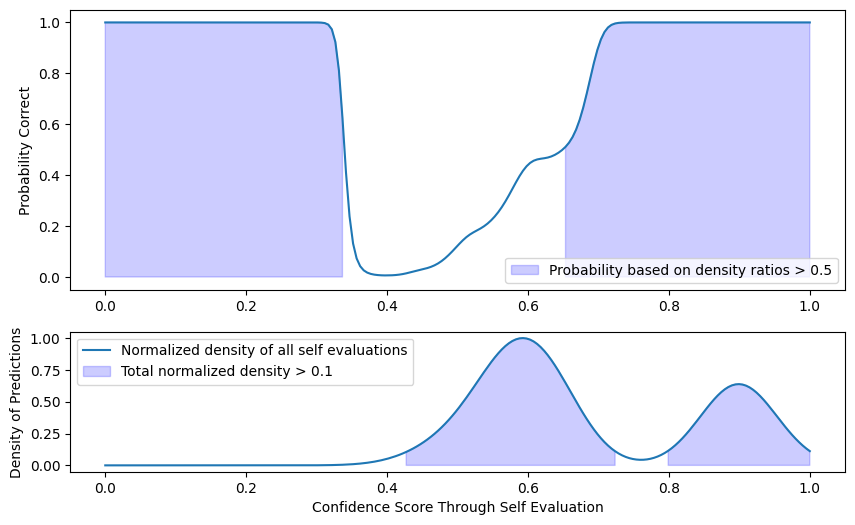

In [69]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6))

total_kde = gaussian_kde(self_eval, bw_method=0.3)
total_density = total_kde(confidence_range)
height_normalized_total_density = total_density/max(total_density)
confidence_threshold = 0.5
density_threshold = 0.1

#marking
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
plt.plot(confidence_range, good_probability)
threshold = 0.5
plt.fill_between(confidence_range, good_probability, 0, where=(good_probability > confidence_threshold), color='blue', alpha=0.2, label=f'Probability based on density ratios > {confidence_threshold}')
plt.ylabel("Probability Correct")
plt.legend()

ax2 = fig.add_subplot(gs[1])
plt.plot(confidence_range, height_normalized_total_density, label="Normalized density of all self evaluations", alpha=1)
plt.fill_between(confidence_range, height_normalized_total_density, 0, where=(height_normalized_total_density > density_threshold), color='blue', alpha=0.2, label=f'Total normalized density > {density_threshold}')
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Density of Predictions")
plt.legend()
plt.show()

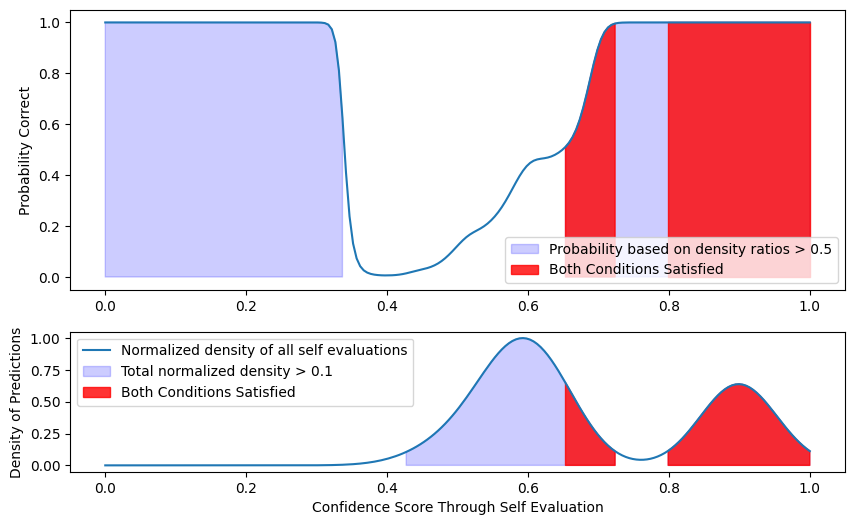

In [70]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6))

total_kde = gaussian_kde(self_eval, bw_method=0.3)
total_density = total_kde(confidence_range)
height_normalized_total_density = total_density/max(total_density)
confidence_threshold = 0.5
density_threshold = 0.1

#marking
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
plt.plot(confidence_range, good_probability)
threshold = 0.5
plt.fill_between(confidence_range, good_probability, 0, where=(good_probability > confidence_threshold), color='blue', alpha=0.2, label=f'Probability based on density ratios > {confidence_threshold}')
plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > confidence_threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.8, label=f'Both Conditions Satisfied')
plt.ylabel("Probability Correct")
plt.legend()

ax2 = fig.add_subplot(gs[1])
plt.plot(confidence_range, height_normalized_total_density, label="Normalized density of all self evaluations", alpha=1)
plt.fill_between(confidence_range, height_normalized_total_density, 0, where=(height_normalized_total_density > density_threshold), color='blue', alpha=0.2, label=f'Total normalized density > {density_threshold}')
plt.fill_between(confidence_range, height_normalized_total_density, 0, where=(np.logical_and(good_probability > confidence_threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.8, label=f'Both Conditions Satisfied')
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Density of Predictions")
plt.legend()
plt.show()

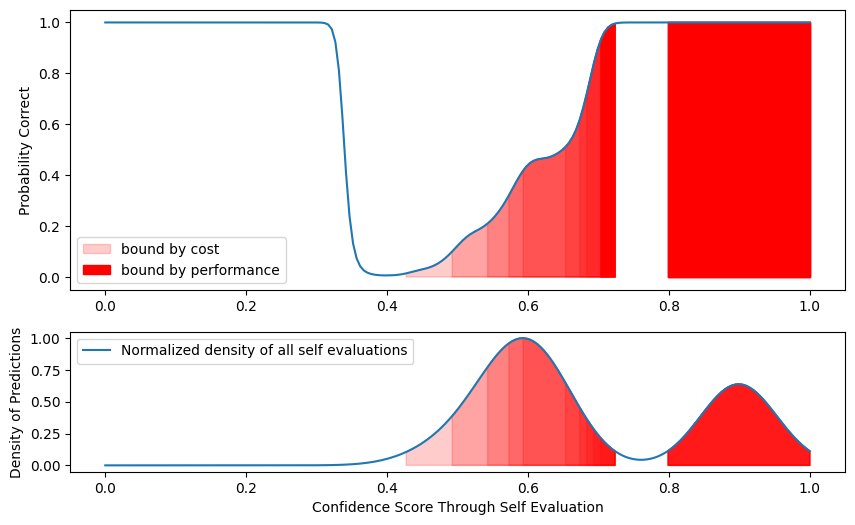

In [71]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6))

total_kde = gaussian_kde(self_eval, bw_method=0.3)
total_density = total_kde(confidence_range)
height_normalized_total_density = total_density/max(total_density)
confidence_threshold = 0.5
density_threshold = 0.1

cost_based_thresholds = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#marking
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
plt.plot(confidence_range, good_probability)
threshold = 0.5

threshold = cost_based_thresholds[0]
plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.2, label=f'bound by cost')

for threshold in cost_based_thresholds[1:-2]:
    plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.2)

threshold = cost_based_thresholds[-1]
plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=1, label=f'bound by performance')

plt.ylabel("Probability Correct")
plt.legend()

ax2 = fig.add_subplot(gs[1])
plt.plot(confidence_range, height_normalized_total_density, label="Normalized density of all self evaluations", alpha=1)
for threshold in cost_based_thresholds:
    plt.fill_between(confidence_range, height_normalized_total_density, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.2)
plt.xlabel("Confidence Score Through Self Evaluation")
plt.ylabel("Density of Predictions")
plt.legend()
plt.show()

# Using this information to build a POMDP

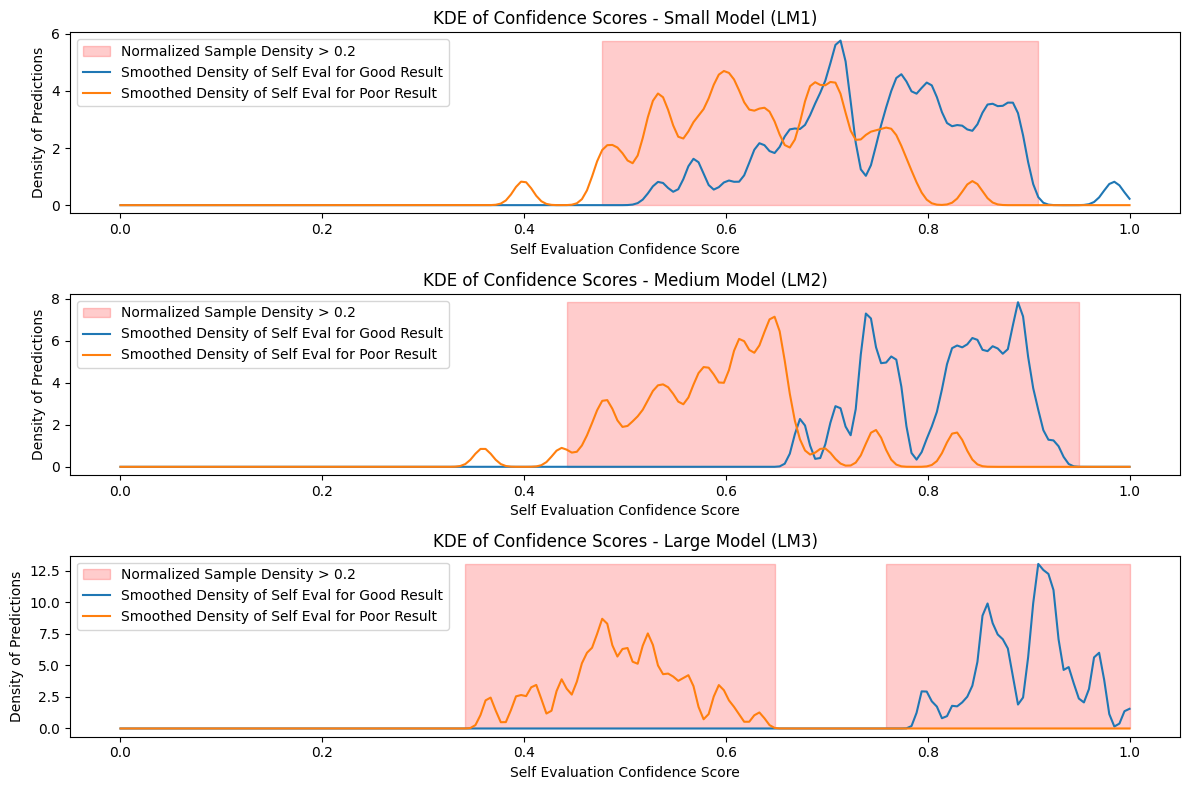

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Simulate confidence scores for three language models (LM1, LM2, LM3) with increasing discernment

# Small Model (LM1) - Overlapping distributions
good_confidences_lm1 = np.random.normal(0.75, 0.1, 50)  # Good: centered around 0.75
poor_confidences_lm1 = np.random.normal(0.65, 0.1, 50)  # Poor: centered around 0.65

# Medium Model (LM2) - Some separation
good_confidences_lm2 = np.random.normal(0.8, 0.08, 50)  # Good: centered around 0.8
poor_confidences_lm2 = np.random.normal(0.6, 0.08, 50)  # Poor: centered around 0.6

# Large Model (LM3) - Clear separation
good_confidences_lm3 = np.random.normal(0.9, 0.05, 50)  # Good: centered around 0.9
poor_confidences_lm3 = np.random.normal(0.5, 0.05, 50)  # Poor: centered around 0.5

# Define KDEs for each model's performance state
kde_good_lm1 = gaussian_kde(good_confidences_lm1, bw_method=0.1)
kde_poor_lm1 = gaussian_kde(poor_confidences_lm1, bw_method=0.1)
kde_density_lm1 = gaussian_kde(np.append(good_confidences_lm1, poor_confidences_lm1), bw_method=0.3)

kde_good_lm2 = gaussian_kde(good_confidences_lm2, bw_method=0.1)
kde_poor_lm2 = gaussian_kde(poor_confidences_lm2, bw_method=0.1)
kde_density_lm2 = gaussian_kde(np.append(good_confidences_lm2, poor_confidences_lm2), bw_method=0.3)

kde_good_lm3 = gaussian_kde(good_confidences_lm3, bw_method=0.1)
kde_poor_lm3 = gaussian_kde(poor_confidences_lm3, bw_method=0.1)
kde_density_lm3 = gaussian_kde(np.append(good_confidences_lm3, poor_confidences_lm3), bw_method=0.3)

# Confidence range for visualization
confidence_range = np.linspace(0.0, 1.0, 200)

# Evaluate KDEs over the confidence range
good_densities_lm1 = kde_good_lm1(confidence_range)
poor_densities_lm1 = kde_poor_lm1(confidence_range)
densities_lm1 = kde_density_lm1(confidence_range)
densities_lm1 = densities_lm1/max(densities_lm1)

good_densities_lm2 = kde_good_lm2(confidence_range)
poor_densities_lm2 = kde_poor_lm2(confidence_range)
densities_lm2 = kde_density_lm2(confidence_range)
densities_lm2 = densities_lm2/max(densities_lm2)

good_densities_lm3 = kde_good_lm3(confidence_range)
poor_densities_lm3 = kde_poor_lm3(confidence_range)
densities_lm3 = kde_density_lm3(confidence_range)
densities_lm3 = densities_lm3/max(densities_lm3)

# Plot the KDEs for each model
plt.figure(figsize=(12, 8))

density_threshold = 0.2

# LM1 Plot
plt.subplot(3, 1, 1)
plt.fill_between(confidence_range, [np.max(np.append(good_densities_lm1, poor_densities_lm1))]*len(confidence_range), 0, where=(densities_lm1>density_threshold), color='red', alpha=0.2, label=f'Normalized Sample Density > {density_threshold}')
plt.plot(confidence_range, good_densities_lm1, label="Smoothed Density of Self Eval for Good Result")
plt.plot(confidence_range, poor_densities_lm1, label="Smoothed Density of Self Eval for Poor Result")
plt.title("KDE of Confidence Scores - Small Model (LM1)")
plt.xlabel("Self Evaluation Confidence Score")
plt.ylabel("Density of Predictions")
plt.legend()

# LM2 Plot
plt.subplot(3, 1, 2)
plt.fill_between(confidence_range, [np.max(np.append(good_densities_lm2, poor_densities_lm2))]*len(confidence_range), 0, where=(densities_lm2>density_threshold), color='red', alpha=0.2, label=f'Normalized Sample Density > {density_threshold}')
plt.plot(confidence_range, good_densities_lm2, label="Smoothed Density of Self Eval for Good Result")
plt.plot(confidence_range, poor_densities_lm2, label="Smoothed Density of Self Eval for Poor Result")
plt.title("KDE of Confidence Scores - Medium Model (LM2)")
plt.xlabel("Self Evaluation Confidence Score")
plt.ylabel("Density of Predictions")
plt.legend()

# LM3 Plot
plt.subplot(3, 1, 3)
plt.fill_between(confidence_range, [np.max(np.append(good_densities_lm3, poor_densities_lm3))]*len(confidence_range), 0, where=(densities_lm3>density_threshold), color='red', alpha=0.2, label=f'Normalized Sample Density > {density_threshold}')
plt.plot(confidence_range, good_densities_lm3, label="Smoothed Density of Self Eval for Good Result")
plt.plot(confidence_range, poor_densities_lm3, label="Smoothed Density of Self Eval for Poor Result")
plt.title("KDE of Confidence Scores - Large Model (LM3)")
plt.xlabel("Self Evaluation Confidence Score")
plt.ylabel("Density of Predictions")
plt.legend()

plt.tight_layout()
plt.show()

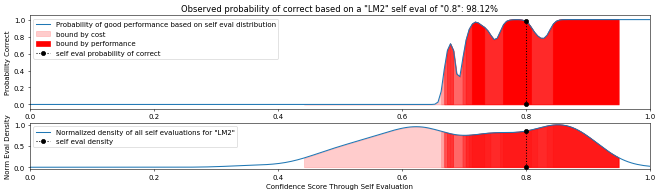

In [73]:
def observe_good_probability(self_eval, kde_good, kde_bad, total_kde, normalized_density_threshold=0.2, model_name=None, plot=False):
    """Calculated the probability of a good prediction, modified by the normalized
    density of all predictions. The reason this is called "observe" is because,
    formally, POMDPs employ "observations" which are probabalistic in nature,
    based on the true state of what's happening.
    """

    #computing normalization scaling factor for the density for all data
    confidence_range = np.linspace(0.0, 1.0, 200)
    scaling_coefficient = 1/max(total_kde(confidence_range))

    #Calculating the normalized density at the self evaluation
    normalized_density = total_kde(self_eval)*scaling_coefficient

    returnval = 0

    #if the region doesn't have enough data, returning a good probability of zero
    if normalized_density<normalized_density_threshold:
        returnval = 0

    #calculating the probability that the prediction is good based on density
    else:
        returnval = kde_good(self_eval)/(kde_good(self_eval)+kde_bad(self_eval))
        returnval = returnval[0]

    #Plotting
    if plot:
        fig = plt.figure(figsize=(16, 4), dpi=50)
        confidence_range = np.linspace(0.0, 1.0, 200)

        #evaluating KDEs across x axis
        good_density= kde_good(confidence_range)
        poor_density = kde_bad(confidence_range)
        total_density = total_kde(confidence_range)

        #Creating normalized density curve
        height_normalized_total_density = total_density/max(total_density)

        #Creating Probability of Good Curve
        with np.errstate(invalid='ignore'):
            good_probability = good_density/(good_density+poor_density)
            good_probability[np.isnan(good_probability)] = 0

        #for rendering
        cost_based_thresholds = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

        #Plotting Probability of Correct Prediction
        gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
        ax1 = fig.add_subplot(gs[0])
        plt.plot(confidence_range, good_probability, label=f'Probability of good performance based on self eval distribution')

        threshold = cost_based_thresholds[0]
        plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.2, label=f'bound by cost')

        for threshold in cost_based_thresholds[1:-2]:
            plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.2)

        threshold = cost_based_thresholds[-1]
        plt.fill_between(confidence_range, good_probability, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=1, label=f'bound by performance')

        plt.ylabel("Probability Correct")
        plt.title(f'Observed probability of correct based on a "{model_name}" self eval of "{self_eval}": {returnval*100:.2f}%')
        plt.plot([self_eval,self_eval], [0, returnval], 'k:o', label='self eval probability of correct')
        plt.xlim(0, 1)
        plt.legend()

        #Plotting Normalized Density of All Predictions
        ax2 = fig.add_subplot(gs[1])
        plt.plot(confidence_range, height_normalized_total_density, label=f'Normalized density of all self evaluations for "{model_name}"', alpha=1)
        for threshold in cost_based_thresholds:
            plt.fill_between(confidence_range, height_normalized_total_density, 0, where=(np.logical_and(good_probability > threshold, height_normalized_total_density > density_threshold)), color='red', alpha=0.2)
        plt.xlabel("Confidence Score Through Self Evaluation")
        plt.ylabel("Norm Eval Density")
        plt.plot([self_eval,self_eval], [0, total_kde(self_eval)[0]*scaling_coefficient], 'k:o', label='self eval density')
        plt.xlim(0, 1)
        plt.legend()

    return returnval

kde_good_lm2 = gaussian_kde(good_confidences_lm2, bw_method=0.1)
kde_poor_lm2 = gaussian_kde(poor_confidences_lm2, bw_method=0.1)
kde_density_lm2 = gaussian_kde(np.append(good_confidences_lm2, poor_confidences_lm2), bw_method=0.3)

observe_good_probability(0.8, kde_good_lm2, kde_poor_lm2, kde_density_lm2, model_name='LM2', plot=True)
plt.show()

Example 1. Cost factor is 0.5:
  LM1's self-evaluation score: 0.84


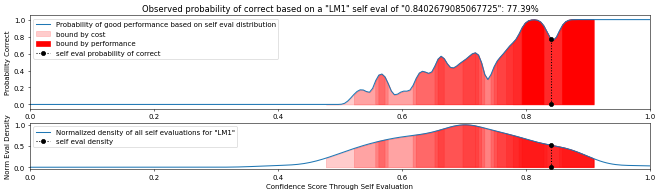

  Reward for LM1: 0.17 (probability good: 77.39%, cost of next: 1.2)
  Decision: Stick with LM1. Probability of good prediction: 77.39%

Example 2. Cost factor is 0.5:
  LM1's self-evaluation score: 0.89


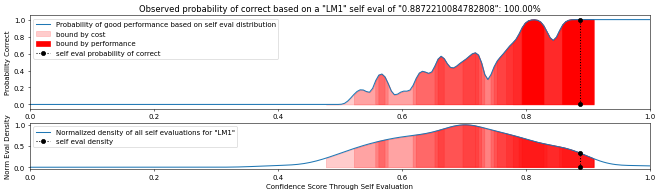

  Reward for LM1: 0.40 (probability good: 100.00%, cost of next: 1.2)
  Decision: Stick with LM1. Probability of good prediction: 100.00%

Example 3. Cost factor is 0.5:
  LM1's self-evaluation score: 0.98


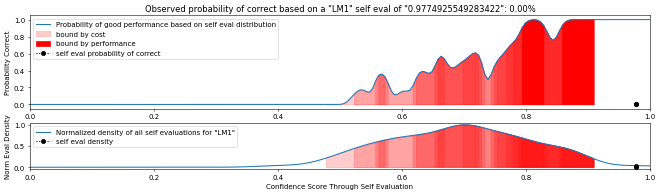

  Reward for LM1: -0.60 (probability good: 0.00%, cost of next: 1.2)
  Escalating from LM1. Reward was -0.60

  LM2's self-evaluation score: 0.61


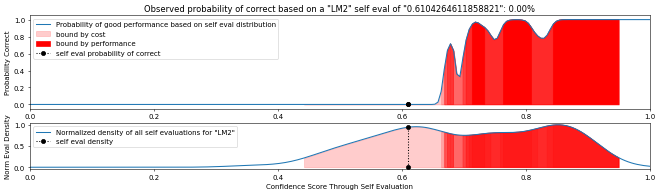

  Reward for LM2: -0.75 (probability good: 0.00%, cost of next: 1.5)
  Escalating from LM2. Reward was -0.75

  LM3's self-evaluation score: 0.90


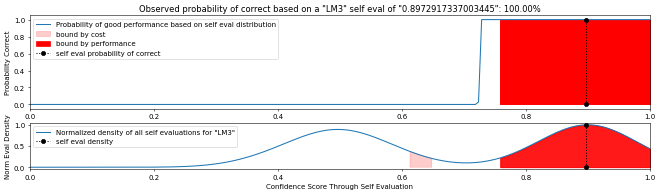

  Decision: Stick with LM3. Probability of good prediction: 100.00%

Example 4. Cost factor is 0.5:
  LM1's self-evaluation score: 0.87


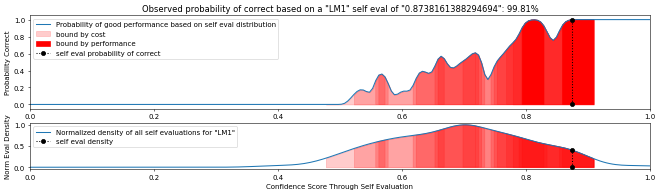

  Reward for LM1: 0.40 (probability good: 99.81%, cost of next: 1.2)
  Decision: Stick with LM1. Probability of good prediction: 99.81%

Example 5. Cost factor is 0.5:
  LM1's self-evaluation score: 0.92


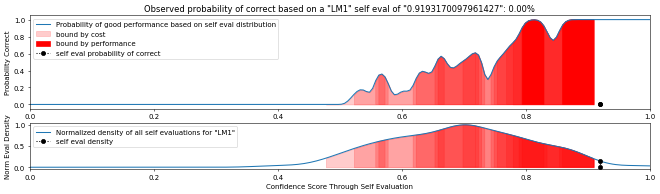

  Reward for LM1: -0.60 (probability good: 0.00%, cost of next: 1.2)
  Escalating from LM1. Reward was -0.60

  LM2's self-evaluation score: 0.87


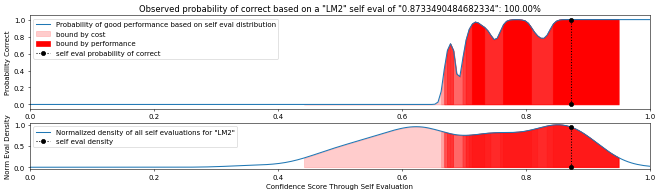

  Reward for LM2: 0.25 (probability good: 100.00%, cost of next: 1.5)
  Decision: Stick with LM2. Probability of good prediction: 100.00%



In [77]:
class Model:
    def __init__(self, name, kde_good, kde_poor, kde_density, good_threshold, cost):
        """
        Initialize each model with KDEs for good/poor predictions, a good_threshold for trusting its output,
        and a cost associated with using this model.
        """
        self.name = name
        self.kde_good = kde_good
        self.kde_poor = kde_poor
        self.kde_density = kde_density
        self.good_threshold = good_threshold
        self.cost = cost

    def evaluate(self, self_eval, density_threshold=0.2):
        """Calculate the probability that the prediction is good based on the self evaluation score."""
        prob_good = observe_good_probability(self_eval, self.kde_good, self.kde_poor, self.kde_density,
                                             normalized_density_threshold=density_threshold, model_name=self.name, plot=True)
        plt.show()
        return prob_good


class POMDP:
    def __init__(self, models, lambda_param=0.1):
        """
        Initialize the POMDP with a list of models and the lambda parameter that balances performance vs. cost.
        """
        self.models = models
        self.lambda_param = lambda_param  # Parameter to balance cost vs. performance in reward function

    def compute_reward(self, prob_good, cost):
        """
        Compute the reward based on the performance (prob_good) and the cost of the model.
        """
        return prob_good - self.lambda_param * cost

    def run_simulation(self, n_examples=5):
        """Run the POMDP decision process across multiple examples."""
        for example in range(n_examples):
            print(f"Example {example + 1}. Cost factor is {self.lambda_param}:")
            for model_iter, model in enumerate(self.models):
                self_eval = np.random.uniform(0.6, 1.0)  # Generate a random self-evaluation score
                print(f"  {model.name}'s self-evaluation score: {self_eval:.2f}")
                prob_good = model.evaluate(self_eval)

                # Compute reward based on the current model's performance and cost
                if model_iter<len(self.models)-1:
                    reward = self.compute_reward(prob_good, self.models[model_iter+1].cost)
                    print(f"  Reward for {model.name}: {reward:.2f} (probability good: {prob_good*100:.2f}%, cost of next: {self.models[model_iter+1].cost})")
                else:
                    reward = 1 #no more models to escelate to

                # Decision: Should we trust this model or escalate?
                if reward > 0:  # If the reward is positive, we trust the model
                    print(f"  Decision: Stick with {model.name}. Probability of good prediction: {prob_good*100:.2f}%\n")
                    break  # Stop traversing as we trust this model
                else:
                    print(f"  Escalating from {model.name}. Reward was {reward:.2f}\n")
            else:
                print("  No suitable model found, escalating failed.\n")


# Define models dynamically with their respective KDEs, thresholds, and costs
lm1 = Model("LM1", kde_good_lm1, kde_poor_lm1, kde_density_lm1, good_threshold=0.8, cost=1)
lm2 = Model("LM2", kde_good_lm2, kde_poor_lm2, kde_density_lm2, good_threshold=0.85, cost=1.2)
lm3 = Model("LM3", kde_good_lm3, kde_poor_lm3, kde_density_lm3, good_threshold=0.9, cost=1.5)

# Initialize the POMDP with the list of models and the lambda parameter (balancing performance vs cost)
pomdp = POMDP(models=[lm1, lm2, lm3], lambda_param=0.5)

# Run the simulation
pomdp.run_simulation(n_examples=5)
